Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


In [3]:
from re import A
%cd /content/drive/MyDrive/CNN Assignment

/content/drive/MyDrive/CNN Assignment


In [4]:
%ls

'Skin cancer ISIC The International Skin Imaging Collaboration'/


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [8]:
## Print the number of images provided in Train and Test folders
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('No of images in Train DS:', image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('No of images in Test DS:', image_count_test)

No of images in Train DS: 2239
No of images in Test DS: 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = 'training',
    image_size=(img_height, img_width),
    batch_size=batch_size

)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = 'validation',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

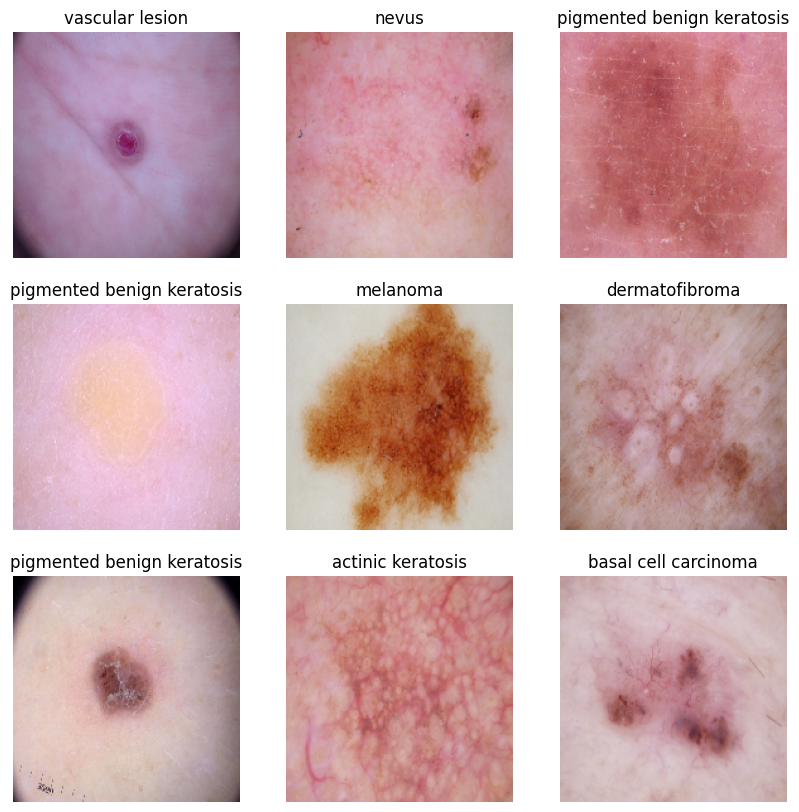

In [13]:
import matplotlib.pyplot as plt

num_classes = 9
### your code goes here, you can use training or validation data to visualize

## Displaying images from Training Data Set
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()

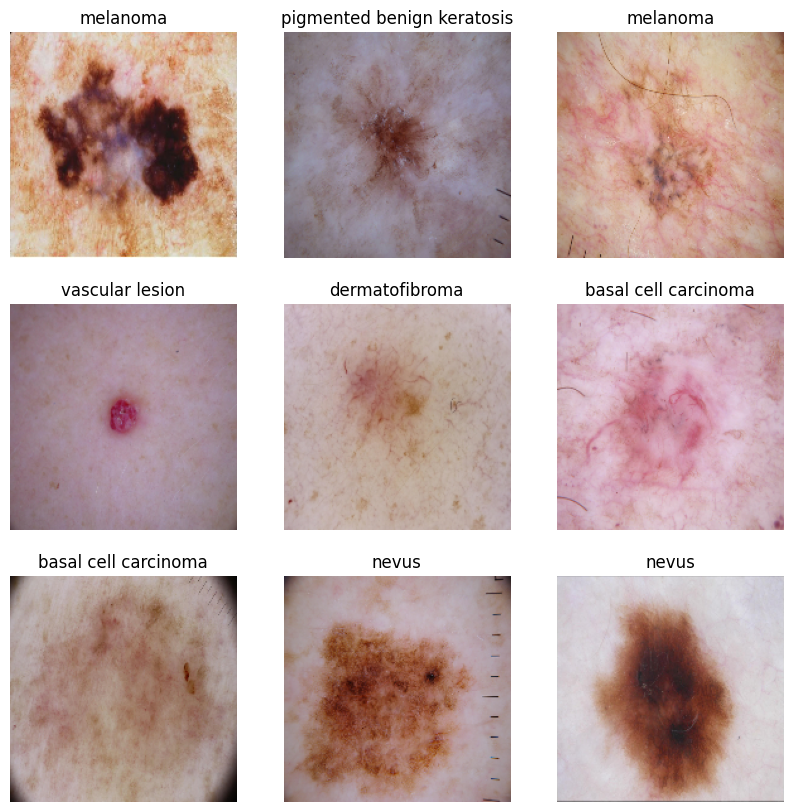

In [14]:
import matplotlib.pyplot as plt


## Displaying images from Validation Data Set

num_classes = 9
plt.figure(figsize=(10, 10))

for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
### Your code goes here
# Setting up Rescaling values
normalization_layer = tf.keras.layers.Rescaling(1./255)



In [19]:
#Nomalize the data in and print the pixel values for one image. It should be between 0 and 1
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.03274596 0.89682335


In [20]:
# model architecture

## Building Model Architecture

## From the given data set, number of Classes = 9
## Use Sequential Modeling
##
## First Convoultion Layer - 32, (3,3) with relu Activation function and perform default (2,2) Maxpooling
## Apply a 25% dropout
##
## Second Convolution Layer - 64, (3,3) with relu Activation function and perform default (2,2) Maxpooling
## Apply a 25% dropout
##
## Flatten the model, apply Dense function with relu Activation
## Further perform a final dropout of 5% and finally apply softmax activation function

num_classes = 9

print(image_batch.shape[1:])

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same'
                 ,input_shape=image_batch.shape[1:]
                 ))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

(180, 180, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [21]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      60,588,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,658,729 (231.39 MB)

 Trainable params: 60,658,729 (231.39 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [23]:
# Train the model with 20 epochs
epochs = 20


history = model.fit(
 train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 533ms/step - accuracy: 0.1604 - loss: 358.0802 - val_accuracy: 0.2125 - val_loss: 2.1578
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2585 - loss: 2.0425 - val_accuracy: 0.3020 - val_loss: 2.0244
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3041 - loss: 1.9133 - val_accuracy: 0.2550 - val_loss: 2.0253
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3392 - loss: 1.8375 - val_accuracy: 0.3870 - val_loss: 1.7011
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.4638 - loss: 1.5650 - val_accuracy: 0.4072 - val_loss: 1.6648
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.4736 - loss: 1.5159 - val_accuracy: 0.4676 - val_loss: 1.5537
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5344 - loss: 1.3291 - val_accuracy: 0.4452 - val_loss: 1.7193
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5834 - loss: 1.2138 - val_accuracy: 0.4318 - val_loss

### Visualizing training results

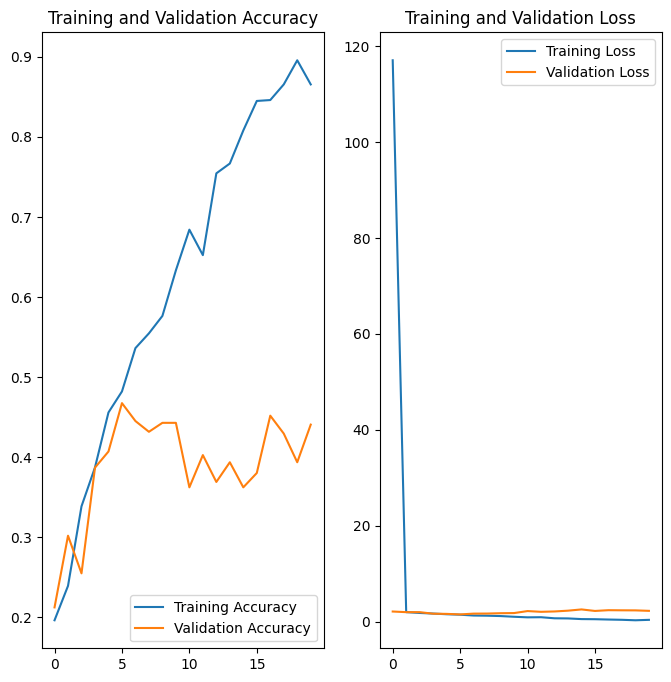

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

From the results printed above:

Epoch 20/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8619 - loss: 0.4590 - val_accuracy: 0.4407 - val_loss: 2.2996


After 20 Epochs, we observe that the training  accuracy is 86% whereas the validation accuracy is 44%.  Clearly there is an **Overfitting** problem here.


In [25]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
# We will try fitting the model with following augumentation strategy
#   1. Use L2 function in FC
#   2. Use Batch Nomalization
#   3. Use Dropout
#   4. Use Data Augmentation with RandomFlip, RandomRotation, RandomCrop functions


data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.RandomCrop(img_height,img_width),
  ]
)




/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


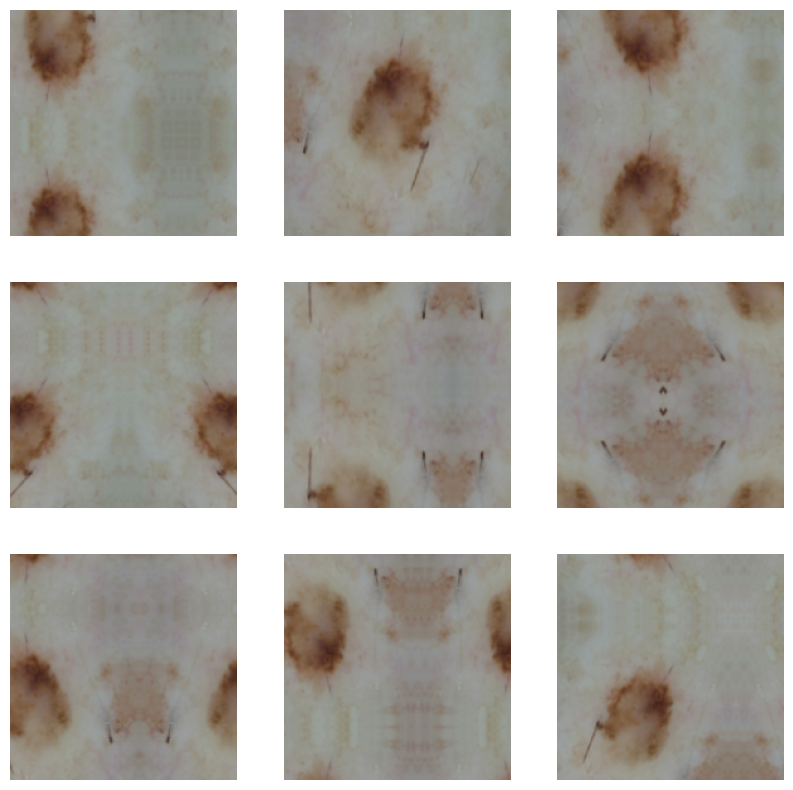

In [26]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")




### Todo:
### Create the model, compile and train the model


In [27]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

# model architecture

## From the given data set, number of Classes = 9
## Use Sequential Modeling
##
## First Convoultion Layer - 32, (3,3) with relu Activation function, followed by Batch Nomalization and performing default (2,2) Maxpooling
## Apply a 25% dropout
##
## Second Convolution Layer - 64, (3,3) with relu Activation function, followed by Batch Nomalization and performing default (2,2) Maxpooling
##
## Third Convolution Layer -  128, (3,3) with relu Activation function, followed by Batch Nomalization and performing default (2,2) Maxpooling
##
## Fourth Convolution Layer - 256, (3,3) with relu Activation function, followed by Batch Nomalization and performing default (2,2) Maxpooling
## Apply a 20% dropout
##
## Flatten the model, apply Dense function with L2 Regulaiztion along with relu Activation
## Finally apply softmax activation function

num_classes = 9

print(image_batch.shape[1:])

model = Sequential()

model.add(data_augmentation)

model.add(Conv2D(32, (3, 3), padding='same'
                 ,input_shape=image_batch.shape[1:]
                 ))
model.add(Activation('relu'))
model.add(BatchNormalization())
#model.add(Conv2D(32, (3, 3)))
#model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))



(180, 180, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compiling the model

In [28]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [33]:
## Your code goes here, note: train your model for 20 epochs

## Fitting model with 20 epochs
epochs = 20


history = model.fit(
 train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.4817 - loss: 1.4836 - val_accuracy: 0.3893 - val_loss: 2.0186
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5052 - loss: 1.4224 - val_accuracy: 0.4653 - val_loss: 1.6936
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.4935 - loss: 1.4686 - val_accuracy: 0.4228 - val_loss: 1.7119
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.4895 - loss: 1.4855 - val_accuracy: 0.4541 - val_loss: 1.6486
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5048 - loss: 1.4713 - val_accuracy: 0.3826 - val_loss: 1.9687
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.4860 - loss: 1.4875 - val_accuracy: 0.2506 - val_loss: 2.4616
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5102 - loss: 1.4412 - val_accuracy: 0.1969 - val_loss: 21.6117
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.4855 - loss: 1.4416 - val_accuracy: 0.4183 - 

### Visualizing the results

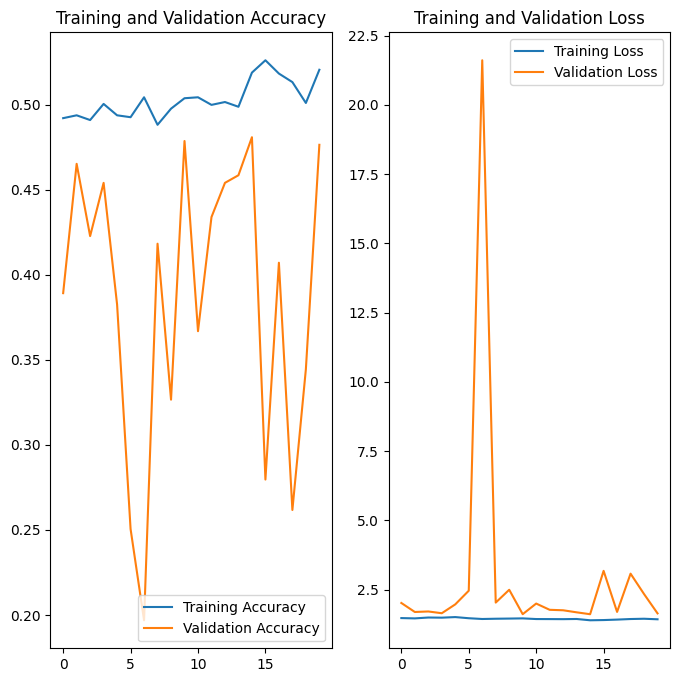

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**OBSERVATIONS**:

From the results above, we see the following line for Epoch 20
Epoch 20/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5274 - loss: 1.4302 - val_accuracy: 0.4765 - val_loss: 1.6431


After the above augumentation techniques, we find that after 20 epochs, the model is still **Overfitting**.

Training accuracy is 52.7% whereas the validation accuracy is 47.7%

Training accuracy has reduced since the previous modeling and the gap with Validation DS is also narrowed down after adopting the augumentaion strategy

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [35]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [36]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,nevus
2235,Skin cancer ISIC The International Skin Imagin...,nevus
2236,Skin cancer ISIC The International Skin Imagin...,nevus
2237,Skin cancer ISIC The International Skin Imagin...,nevus


Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Total Number of Classes: 9
Total Number of Images: 2239

Class Name                      Number of Images    
actinic keratosis               114 (5.092%)
basal cell carcinoma            376 (16.793%)
dermatofibroma                  95 (4.243%)
melanoma                        438 (19.562%)
nevus                           357 (15.945%)
pigmented benign keratosis      462 (20.634%)
seborrheic keratosis            77 (3.439%)
squamous cell carcinoma         181 (8.084%)
vascular lesion                 139 (6.208%)


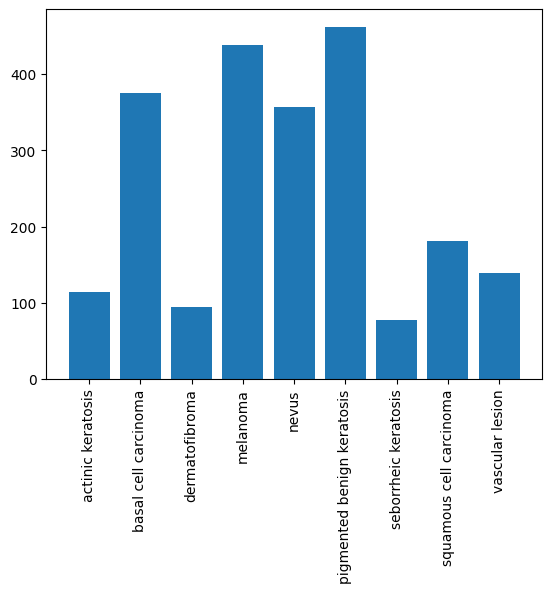

In [38]:
## Your code goes here.
## Store the training dataset from the original data.

## Display the distribution of number of images across the 9 classes in a bar graph
train_ds1 =  tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = 'training',
    image_size=(img_height, img_width),
    batch_size=batch_size

)

class_names1 = train_ds1.class_names


num_classes1 = len(class_names1)

print('Total Number of Classes:', num_classes1)
image_count = len(list(data_dir_train.glob('*/*.jpg')))
print('Total Number of Images:', image_count)

img_dict = {}
label1='Class Name'
label2= 'Number of Images'
print('\n%-30s  %-20s' % (label1, label2))
print('='*50)
for i in range(num_classes1):
    path1 = class_names1[i] + '/*.jpg'
    #print(path1)
    img_dict[class_names1[i]] = len(list(data_dir_train.glob(path1)))
    pct = (img_dict[class_names1[i]]/image_count)*100
    print('%-31s %d (%.3f%%)' % (class_names1[i], img_dict[class_names1[i]], pct))

plt.bar(range(len(img_dict)), list(img_dict.values()), align='center')
plt.xticks(range(len(img_dict)), list(img_dict.keys()),rotation=90)
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

**OBSERVATIONS**

Class seborrheic keratosis has the least number of samples ==> 77

Class pigmented benign keratosis and melanoma dominate the data in terms of proporionate number of samples with 20.6% and 19.5%  with their sample sies are 462 and 438 respectively.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [39]:
!pip install Augmentor

In [40]:
# Print Training Dataset directory
print(data_dir_train)

Skin cancer ISIC The International Skin Imaging Collaboration/Train


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [41]:
path_to_training_dataset="/content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C9E74107F40>: 100%|██████████| 500/500 [00:04<00:00, 111.37 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C9E74203B50>: 100%|██████████| 500/500 [00:04<00:00, 106.80 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C9E843D24D0>: 100%|██████████| 500/500 [00:04<00:00, 105.66 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C9E941BB490>: 100%|██████████| 500/500 [00:13<00:00, 37.11 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C9E84590F70>: 100%|██████████| 500/500 [00:14<00:00, 33.58 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C9E84790A00>: 100%|██████████| 500/500 [00:04<00:00, 109.61 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C9E847931C0>: 100%|██████████| 500/500 [00:07<00:00, 70.92 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C9E743D3040>: 100%|██████████| 500/500 [00:04<00:00, 108.94 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C9E8428AB30>: 100%|██████████| 500/500 [00:04<00:00, 112.37 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [43]:
## Display the total number of images augmented which should be 9 * 500 = 4500
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [44]:
## Create a folder called Output in each of the 9 directories (Classes) and add 500 new images on each one of them
import os
from glob import glob # Import the glob function

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031609.jpg_389ca2ed-0242-463a-8973-d2835b4ec510.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029915.jpg_808e4ddf-c6e6-4823-a8a5-d260dc6a8d77.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029830.jpg_8ef5dbf5-507b-48f3-9f70-fd7995010f13.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025957.jpg_8226a49a-b06e-4ecd-8a82-88c9f645b8c4.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033811.jpg_b5a138e1-0c8a-4604-b0a6-ecb036b4ad75.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ou

In [45]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [46]:
## Create a new dataframe with the Path and Label
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [47]:
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,nevus
2235,Skin cancer ISIC The International Skin Imagin...,nevus
2236,Skin cancer ISIC The International Skin Imagin...,nevus
2237,Skin cancer ISIC The International Skin Imagin...,nevus


In [48]:
## Create a new dataframe with path and label and append newly created augumented data to the original data.  This should result in total number of images in each class by 500 more
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [50]:
new_df = pd.concat([original_df, df2])

In [52]:
## Display number of images in each of the classes. There should be 500 more images added to the original count.
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [53]:
batch_size = 32
img_height = 180
img_width = 180

In [55]:
## Display the path of data_dir_train to be used for modeling.
data_dir_train

PosixPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train')

#### **Todo:** Create a training dataset

In [56]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [57]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [58]:
## your code goes here

## Building Model Architecture

## From the given data set, number of Classes = 9
## Use Sequential Modeling
##
## First Convoultion Layer - 16, (3,3) with relu Activation function and perform Maxpooling
##
## Second Convolution Layer - 32, (3,3) with relu Activation function and perform Maxpooling
##
## Third Convolution Layer - 64, (3,3) with relu Activation function and perform Maxpooling
## Apply a 20% dropout
##
## Flatten the model, apply Dense function with relu Activation


AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [59]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [60]:
## Train model with 30 epochs
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.1996 - loss: 2.1113 - val_accuracy: 0.3623 - val_loss: 1.6049
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4626 - loss: 1.4462 - val_accuracy: 0.5471 - val_loss: 1.2725
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5720 - loss: 1.1770 - val_accuracy: 0.5857 - val_loss: 1.1270
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6435 - loss: 0.9731 - val_accuracy: 0.6578 - val_loss: 0.9754
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7212 - loss: 0.7938 - val_accuracy: 0.6927 - val_loss: 0.8745
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7634 - loss: 0.6765 - val_accuracy: 0.7112 - val_loss: 0.8256
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8090 - loss: 0.5262 - val_accuracy: 0.7520 - val_loss: 0.7324
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8480 - loss: 0.4242 - val_acc

#### **Todo:**  Visualize the model results

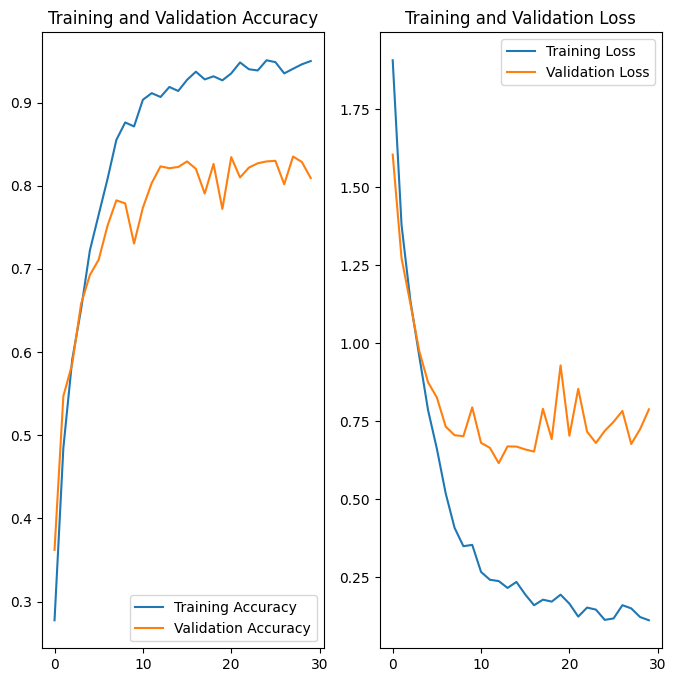

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**OBSERVATIONS**:

After adding 500 images in each folder and fitting the model with 30 epochs, we observe the following:

1. From the results above we see that:

Epoch 30/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9537 - loss: 0.1053 - val_accuracy: 0.8092 - val_loss: 0.7878


2. The Training accuracy has improved to 95.3% whereas the Validation Accuracy is at 80.9%.

3. Still we are having an **overfitting** problem even though the accuracies of both Training and Validation have improved significantly.

In [62]:
## Applying the model on test dataset

##1. Create Test ds

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)




Found 118 files belonging to 9 classes.


In [63]:
## 2. Nomalize Test Data set
AUTOTUNE = tf.data.experimental.AUTOTUNE

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [64]:
## Evaluate test data set
model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3835 - loss: 7.5948


[8.06518840789795, 0.37288135290145874]

**OBSERVATIONS**

After evaluating the Test Data Set, we get a model accurac of 38.35%